<a href="https://colab.research.google.com/github/MunJeongHyeon/Deeplearning/blob/main/HW2_MJH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Mar 31 22:57:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow
tensorflow.keras.__version__

'2.4.0'

# Classifying movie reviews: a binary classification example

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----


Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. In this example, we 
will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.

## The IMDB dataset


We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Why do we have these two separate training and test sets? You should never test a machine learning model on the same data that you used to 
train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and 
what you actually care about is your model's performance on new data (since you already know the labels of your training data -- obviously 
you don't need your model to predict those). For instance, it is possible that your model could end up merely _memorizing_ a mapping between 
your training samples and their targets -- which would be completely useless for the task of predicting targets for data never seen before. 
We will go over this point in much more detail in the next chapter.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) 
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [3]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 


The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words 
will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). 
`train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [ ]:
train_data[0]

In [5]:
train_labels[0]

1

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [6]:
max([max(sequence) for sequence in train_data])

9999

For kicks, here's how you can quickly decode one of these reviews back to English words:

In [7]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1646592/1641221 [==============================] - 0s 0us/step


In [8]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [10]:
decoded_review_1 = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[1]])
decoded_review_1

"? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

## Preparing the data


We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape `(samples, word_indices)`, 
then use as first layer in our network a layer capable of handling such integer tensors (the `Embedding` layer, which we will cover in 
detail later in the book).
* We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence 
`[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as 
first layer in our network a `Dense` layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

In [11]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [12]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should also vectorize our labels, which is straightforward:

In [13]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [14]:
train_labels[:5]

array([1, 0, 0, 1, 0])

Now our data is ready to be fed into a neural network.

## Building our network


Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of 
network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations: `Dense(16, 
activation='relu')`

The argument being passed to each `Dense` layer (16) is the number of "hidden units" of the layer. What's a hidden unit? It's a dimension 
in the representation space of the layer. You may remember from the previous chapter that each such `Dense` layer with a `relu` activation implements 
the following chain of tensor operations:

`output = relu(dot(W, input) + b)`

Having 16 hidden units means that the weight matrix `W` will have shape `(input_dimension, 16)`, i.e. the dot product with `W` will project the 
input data onto a 16-dimensional representation space (and then we would add the bias vector `b` and apply the `relu` operation). You can 
intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when 
learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more 
complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that 
will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many "hidden units" to chose for each layer.

In the next chapter, you will learn formal principles to guide you in making these choices. 
For the time being, you will have to trust us with the following architecture choice: 
two intermediate layers with 16 hidden units each, 
and a third layer which will output the scalar prediction regarding the sentiment of the current review. 
The intermediate layers will use `relu` as their "activation function", 
and the final layer will use a sigmoid activation so as to output a probability 
(a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). 
A `relu` (rectified linear unit) is a function meant to zero-out negative values, 
while a sigmoid "squashes" arbitrary values into the `[0, 1]` interval, thus outputting something that can be interpreted as a probability.

Here's what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

And here's the Keras implementation, very similar to the MNIST example you saw previously:

In [37]:
from tensorflow.keras import models
from tensorflow.keras import layers

origin_model = models.Sequential()
origin_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
origin_model.add(layers.Dense(16, activation='relu'))
origin_model.add(layers.Dense(1, activation='sigmoid'))


Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network 
is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. 
It isn't the only viable choice: you could use, for instance, `mean_squared_error`. But crossentropy is usually the best choice when you 
are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance" 
between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that we will 
also monitor accuracy during training.

In [38]:
origin_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

We are passing our optimizer, loss function and metrics as strings, which is possible because `rmsprop`, `binary_crossentropy` and 
`accuracy` are packaged as part of Keras. Sometimes you may want to configure the parameters of your optimizer, or pass a custom loss 
function or metric function. This former can be done by passing an optimizer class instance as the `optimizer` argument:

The latter can be done by passing function objects as the `loss` or `metrics` arguments:

## Validating our approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by 
setting apart 10,000 samples from the original training data:

In [39]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512 
samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the 
validation data as the `validation_data` argument:

In [40]:
origin_history = origin_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 29ms/step - loss: 0.5968 - accuracy: 0.7086 - val_loss: 0.3833 - val_accuracy: 0.8731
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3268 - accuracy: 0.9008 - val_loss: 0.3027 - val_accuracy: 0.8884
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2349 - accuracy: 0.9251 - val_loss: 0.2783 - val_accuracy: 0.8913
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1720 - accuracy: 0.9476 - val_loss: 0.2913 - val_accuracy: 0.8835
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1450 - accuracy: 0.9572 - val_loss: 0.2845 - val_accuracy: 0.8866
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1143 - accuracy: 0.9676 - val_loss: 0.3174 - val_accuracy: 0.8777
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0934 - accuracy: 0.9739 - val_loss: 0.3118 - val_accuracy: 0.8840
Epoch 8/20
30

In [41]:
from tensorflow.keras import regularizers

l1_model = models.Sequential()
l1_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(10000,)))
l1_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
l1_model.add(layers.Dense(1, activation='sigmoid'))

In [42]:
l1_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [43]:
l1_history = l1_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 27ms/step - loss: 1.5143 - accuracy: 0.6750 - val_loss: 0.7276 - val_accuracy: 0.8282
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.6942 - accuracy: 0.8371 - val_loss: 0.6706 - val_accuracy: 0.8249
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.6387 - accuracy: 0.8442 - val_loss: 0.6184 - val_accuracy: 0.8544
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.5966 - accuracy: 0.8599 - val_loss: 0.5959 - val_accuracy: 0.8571
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.5747 - accuracy: 0.8638 - val_loss: 0.5817 - val_accuracy: 0.8565
Epoch 6/20
30/30 [==============================] - 1s 20ms/step - loss: 0.5573 - accuracy: 0.8684 - val_loss: 0.5659 - val_accuracy: 0.8630
Epoch 7/20
30/30 [==============================] - 1s 20ms/step - loss: 0.5398 - accuracy: 0.8705 - val_loss: 0.5502 - val_accuracy: 0.8637
Epoch 8/20
30

In [44]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

In [45]:
dpt_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
dpt_history = dpt_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 61ms/step - loss: 0.6580 - accuracy: 0.5868 - val_loss: 0.5199 - val_accuracy: 0.8520
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.5297 - accuracy: 0.7534 - val_loss: 0.4238 - val_accuracy: 0.8728
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.4496 - accuracy: 0.8179 - val_loss: 0.3513 - val_accuracy: 0.8738
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3842 - accuracy: 0.8581 - val_loss: 0.3118 - val_accuracy: 0.8864
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3271 - accuracy: 0.8885 - val_loss: 0.2874 - val_accuracy: 0.8856
Epoch 6/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2790 - accuracy: 0.9054 - val_loss: 0.2792 - val_accuracy: 0.8903
Epoch 7/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2463 - accuracy: 0.9183 - val_loss: 0.2772 - val_accuracy: 0.8920
Epoch 8/20
30

In [47]:
history_dict = origin_history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
epochs = range(1, 21)

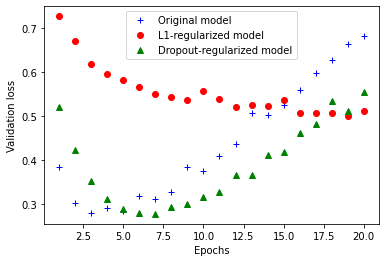

In [49]:
import matplotlib.pyplot as plt

origin_model_val_loss = origin_history.history['val_loss']
l1_model_val_loss = l1_history.history['val_loss']
dpt_model_val_loss = dpt_history.history['val_loss']

plt.plot(epochs, origin_model_val_loss, 'b+', label='Original model')
plt.plot(epochs, l1_model_val_loss, 'ro', label='L1-regularized model')
plt.plot(epochs, dpt_model_val_loss, 'g^', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()